# MedQA Relabelling Analysis

In [2]:
import numpy as np
import functools
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
COLORS = [
    'salmon', 'orange', 'mediumseagreen', 'cornflowerblue'
]

In [4]:
input_file = 'data/benchmarks/medqa_relabelling.csv'
with open(input_file, 'r') as f:
  df = pd.read_csv(f)

In [5]:
df.head()

,Unnamed: 0,time,worker_id,qid,question,A,B,C,D,answer_idx,blind_answerable,blind_answers,info_missing,important_info_missing,seen_change,seen_answerable,seen_answers
0,0,262775,15,116,A 16-year-old boy with a seizure disorder and ...,NF1 gene on chromosome 17,NF2 gene on chromosome 22,TSC1 gene on chromosome 9,VHL gene on chromosome 3,C,True,['C'],False,False,False,NaN,NaN
1,1,336912,5,116,A 16-year-old boy with a seizure disorder and ...,NF1 gene on chromosome 17,NF2 gene on chromosome 22,TSC1 gene on chromosome 9,VHL gene on chromosome 3,C,True,['C'],True,True,False,NaN,NaN
2,2,460740,4,116,A 16-year-old boy with a seizure disorder and ...,NF1 gene on chromosome 17,NF2 gene on chromosome 22,TSC1 gene on chromosome 9,VHL gene on chromosome 3,C,True,['C'],True,True,False,NaN,NaN
3,3,322539,3,883,An immunology expert is delivering a talk on i...,Adenosine deaminase,Caspase 1,Protein phosphatase,Tyrosine kinase,B,True,"['B', 'A']",False,False,True,False,NaN
4,4,574513,5,883,An immunology expert is delivering a talk on i...,Adenosine deaminase,Caspase 1,Protein phosphatase,Tyrosine kinase,B,True,['B'],False,False,False,NaN,NaN


## Voting

In [6]:
def compute_blind_errors(row):
  """Computes blind errors/mis-coverage, if GT is in rater's answers."""
  answer_idx = row['answer_idx']
  responses = row['blind_answers']
  if not isinstance(responses, list):
    # No answer given.
    return True
  return answer_idx not in responses


def compute_seen_errors(row):
  """Computes seen errors/mis-coverage, if GT is in rater's answers."""
  answer_idx = row['answer_idx']
  responses = row['seen_answers']
  if not isinstance(responses, list):
    return True
  return answer_idx not in responses


def select_combined_answers(row):
  """Selects either seen or blind answers depending."""
  responses = row['seen_answers']
  if not isinstance(responses, list):
    # Rater did not change answer after revealing GT.
    responses = row['blind_answers']
  return responses


def select_combined_answerable(row):
  """Selects either seen or blind answerable."""
  if pd.isnull(row['seen_answerable']):
    return row['blind_answerable']
  return row['seen_answerable']


def compute_combined_errors(row):
  """Combined uses seen if seen_change, and blind answers otherwise."""
  answer_idx = row['answer_idx']
  responses = row['combined_answers']
  if not isinstance(responses, list):
    return True
  return answer_idx not in responses


def compute_combined_size(row):
  """Computes size of combined answers."""
  responses = row['combined_answers']
  if not isinstance(responses, list):
    return 0
  return len(responses)


# Convert answers to lists.
df['blind_answers'] = df['blind_answers'].apply(lambda x: eval(x) if isinstance(x, str) else x)
df['seen_answers'] = df['seen_answers'].apply(lambda x: eval(x) if isinstance(x, str) else x)
# Compute rater errors before and after revealing the GT.
df['blind_errors'] = df.apply(compute_blind_errors, axis=1)
df['seen_errors'] = df.apply(compute_seen_errors, axis=1)
# Compute combined answer, answer size = # of selected options, errors.
df['combined_answers'] = df.apply(select_combined_answers, axis=1)
df['combined_size'] = df.apply(compute_combined_size, axis=1)
df['combined_ambiguous'] = df['combined_size'] > 1
df['combined_answerable'] = df.apply(select_combined_answerable, axis=1)
df['combined_errors'] = df.apply(compute_combined_errors, axis=1)
# If info_missing is False, then important_info_missing should also be False.
df['important_info_missing'] = df['important_info_missing'].apply(
    lambda x: x == True)

In [7]:
# Columns that stay the same.
same_keys = [
    'qid', 'question', 'A', 'B', 'C', 'D', 'answer_idx',
]
# Columns that we want to vote over (i.e., aggregate rater opinions for).
vote_keys = [
    'blind_answerable', 'seen_answerable', 'combined_answerable',
    'important_info_missing', 'info_missing',
    'blind_errors', 'seen_errors', 'combined_errors',
    'seen_change', 'combined_ambiguous',
]
keep_keys = ['blind_answers', 'seen_answers', 'combined_answers']
vote_df = df[['qid'] + vote_keys + keep_keys]
core_df = df[same_keys]
core_df = core_df.drop_duplicates(['qid'])
# We aggregate all rater opinions for the columns we want to vote on.
vote_dfs = [core_df]
for vote_key in vote_keys:
  agg_df = vote_df.groupby('qid')[vote_key].apply(list).reset_index()
  vote_dfs.append(agg_df)
for keep_key in keep_keys:
  agg_df = vote_df.groupby('qid')[keep_key].apply(list).reset_index()
  vote_dfs.append(agg_df)
# Merge all the individually aggregated columns.
vote_df = functools.reduce(
    lambda left, right: pd.merge(left, right, on=['qid']), vote_dfs)
# Vote by requiring 2 or 3 rater majority.
for vote_key in vote_keys:
  vote_df[f'sum_{vote_key}'] = vote_df[vote_key].apply(
      lambda xs: np.sum([x if isinstance(x, bool) else False for x in xs]))
  for k in [1, 2, 3]:
    vote_df[f'vote{k}_{vote_key}'] = vote_df[f'sum_{vote_key}'] >= k

## Simulate model predictions

In [8]:
# We target an accuracy of 0.911 (in expectation), but fix an accuracy of 0.98
# on examples that are likely unfilteres; this creates a scenario similar to the paper
# where the model makes more mistakes on examples that are about to be filtered out.
# This is the place where you can load your modal predictions!
np.random.seed(42)
num_filtered = int(np.sum(vote_df['vote1_combined_errors'] == True))
filter_rate = num_filtered/vote_df.shape[0]
accuracy_on_unfiltered = 0.98
accuracy_on_filtered = (
    (0.911 - accuracy_on_unfiltered * (1 - filter_rate)) / filter_rate
)
error_df = vote_df[['vote1_combined_errors', 'qid']]
error_df['error'] = False
error_df.loc[error_df['vote1_combined_errors'] == True, 'error'] = (
    np.random.uniform(0, 1, (num_filtered,)) > accuracy_on_filtered
)
error_df.loc[error_df['vote1_combined_errors'] == False, 'error'] = (
    np.random.uniform(0, 1, (error_df.shape[0] - num_filtered,)) > accuracy_on_unfiltered
)

/tmp/ipykernel_1079751/2439606055.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  error_df['error'] = False


In [9]:
df = pd.merge(df, error_df[['qid', 'error']], on=['qid'])

In [15]:
df["error"]

0       False
1       False
2       False
3       False
4       False
        ...  
3817    False
3818    False
3819    False
3820    False
3821    False
Name: error, Length: 3822, dtype: bool

## Evaluation results

0
1
2
3
4
5
6
7
8
9


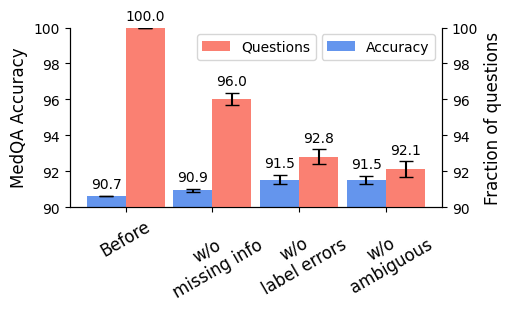

In [12]:
k = 3  # 3 = unanomous voting (main paper), 2 = majority voting (appendix).
n_trials = 10  # 1000 in the paper.
num_questions = []
error_rates = []
agg_df = df.groupby(['qid', 'error']).agg(list).reset_index()
for t in list(range(n_trials)):
  agg_df['sample_info_missing'] = agg_df['info_missing'].apply(
      lambda x: np.sum(np.random.choice(x, 3, replace=True)) >= k)
  agg_df['sample_combined_errors'] = agg_df['combined_errors'].apply(
      lambda x: np.sum(np.random.choice(x, 3, replace=True)) >= k)
  agg_df['sample_combined_ambiguous'] = agg_df['combined_ambiguous'].apply(
      lambda x: np.sum(np.random.choice(x, 3, replace=True)) >= k)

  qs = [
      # All questions.
      agg_df.shape[0],
      # Filter questions that are missing information.
      np.sum(agg_df['sample_info_missing'] == False),
      # Filter label errors.
      np.sum(np.logical_and(
          agg_df['sample_info_missing'] == False,
          agg_df['sample_combined_errors'] == False)),
      # Filter ambiguous questions.
      np.sum(np.logical_and.reduce((
          agg_df['sample_info_missing'] == False,
          agg_df['sample_combined_errors'] == False,
          agg_df['sample_combined_ambiguous'] == False))),
  ]
  es = [
      np.sum(agg_df['error']) / qs[0],
      np.sum(np.logical_and(
          agg_df['error'],
          agg_df['sample_info_missing'] == False
      )) / qs[1],
      np.sum(np.logical_and.reduce((
          agg_df['error'],
          agg_df['sample_info_missing'] == False,
          agg_df['sample_combined_errors'] == False,
      ))) / qs[2],
      np.sum(np.logical_and.reduce((
          agg_df['error'],
          agg_df['sample_info_missing'] == False,
          agg_df['sample_combined_errors'] == False,
          agg_df['sample_combined_ambiguous'] == False,
      ))) / qs[3],
  ]
  num_questions.append(qs)
  error_rates.append(es)
  print(t)
num_questions = np.array(num_questions)
error_rates = np.array(error_rates)

groups = ['Before', 'w/o\nmissing info', 'w/o\nlabel errors', 'w/o\nambiguous']
x = np.arange(len(groups))  # the label locations
width = 0.45  # the width of the bars
multiplier = 0

fig, ax1 = plt.subplots(layout='constrained')
ax2 = ax1.twinx()

for ax, color, label, mean, std in [
    (ax1, COLORS[3], 'Accuracy', 100 * (1 - np.mean(error_rates, axis=0)), np.std(100 * error_rates, axis=0)),
    (ax2, COLORS[0], 'Questions', 100 * np.mean(num_questions / 1273, axis=0), 100 * np.std(num_questions / 1273, axis=0)),
]:
    offset = width * multiplier
    rects = ax.bar(x + offset, mean, yerr=std, width=width, label=label, capsize=5, color=color)
    ax.bar_label(rects, padding=3, fmt='%.1f', label_type='edge')
    multiplier += 1

ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.set_ylabel('MedQA Accuracy', fontsize=12)
ax2.set_ylabel('Fraction of questions', fontsize=12)
ax1.set_xticks(x + width/2, groups, rotation=30, fontsize=12)
ax1.legend(loc='upper right', bbox_to_anchor=(1, 1), ncols=1)
ax2.legend(loc='upper right', bbox_to_anchor=(0.68, 1), ncols=1)
ax1.set_ylim(90, 100)
ax2.set_ylim(90, 100)
ax.grid(False)
plt.gcf().set_size_inches((5, 3))
plt.savefig('medqa_filtering.pdf', dpi=300, format='pdf')
plt.show()

In [58]:
medqa_with_no_nonsense = agg_df[np.logical_and.reduce((
          agg_df['error'] == False,
          agg_df['sample_info_missing'] == False,
          agg_df['sample_combined_errors'] == False,
          agg_df['sample_combined_ambiguous'] == False,))].reset_index(drop = True)

In [59]:
gold_qids = medqa_with_no_nonsense["qid"].values

In [71]:
med_qa_cleaned = df[df["qid"].isin(gold_qids)].drop_duplicates(subset="qid").reset_index(drop = True)

In [72]:
med_qa_cleaned["choices"] = med_qa_cleaned.apply(lambda x: [x["A"], x["B"], x["C"], x["D"]], axis = 1)

med_qa_cleaned

,Unnamed: 0,time,worker_id,qid,question,A,B,C,D,answer_idx,...,seen_answers,blind_errors,seen_errors,combined_answers,combined_size,combined_ambiguous,combined_answerable,combined_errors,error,choices
0,0,262775,15,116,A 16-year-old boy with a seizure disorder and ...,NF1 gene on chromosome 17,NF2 gene on chromosome 22,TSC1 gene on chromosome 9,VHL gene on chromosome 3,C,...,NaN,False,True,[C],1,False,True,False,False,"[NF1 gene on chromosome 17, NF2 gene on chromo..."
1,3,322539,3,883,An immunology expert is delivering a talk on i...,Adenosine deaminase,Caspase 1,Protein phosphatase,Tyrosine kinase,B,...,NaN,False,True,"[B, A]",2,True,False,False,False,"[Adenosine deaminase, Caspase 1, Protein phosp..."
2,6,234064,5,307,A 67-year-old man is brought to the emergency ...,Follow the daughter’s wishes to withhold the o...,Refer this case to the court,Contact another family member for consent,Report the daughter to the police,C,...,NaN,True,True,NaN,0,False,False,True,False,[Follow the daughter’s wishes to withhold the ...
3,9,304300,15,173,A 26-year-old woman comes to the physician bec...,Increase in serum ACTH,Decrease in urinary 17-hydroxycorticosteroids,Decrease in serum 11-deoxycortisol,Increase in serum cortisol,A,...,[A],True,False,[A],1,False,True,False,False,"[Increase in serum ACTH, Decrease in urinary 1..."
4,12,328134,5,335,A 23-year-old man presents with sudden loss of...,Hypertrophic cardiomyopathy,Aortic stenosis,Takotsubo cardiomyopathy,Restrictive cardiomyopathy,A,...,NaN,False,True,[A],1,False,True,False,False,"[Hypertrophic cardiomyopathy, Aortic stenosis,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1074,3807,48821,1,1195,A 14-year-old boy presents to the emergency de...,Radiograph of the wrist,MRI of the wrist,Thumb spica cast,Radial gutter cast,A,...,NaN,False,True,[A],1,False,True,False,False,"[Radiograph of the wrist, MRI of the wrist, Th..."
1075,3810,301923,5,1250,A 37-year-old woman with an HIV infection come...,Efavirenz,Ritonavir,Raltegravir,Lamivudine,A,...,[A],True,False,[A],1,False,True,False,False,"[Efavirenz, Ritonavir, Raltegravir, Lamivudine]"
1076,3813,173518,8,1004,A 66-year-old man presents to the emergency de...,Cefazolin,Ceftriaxone,Levofloxacin,Penicillin,C,...,NaN,False,True,[C],1,False,True,False,False,"[Cefazolin, Ceftriaxone, Levofloxacin, Penicil..."
1077,3816,82114,1,549,"A 6-year-old boy presents with fever, malaise,...",Postviral inflammatory process,Pyriform sinus fistula,Antithyroid peroxidase (TPO),Autoantibodies to the thyrotropin receptor (TRAb),B,...,[B],True,False,[B],1,False,True,False,False,"[Postviral inflammatory process, Pyriform sinu..."


In [75]:
def get_answer_to_question(row):
    column_name = row["answer_idx"]
    return row[column_name]


med_qa_cleaned["answer"] = med_qa_cleaned.apply(lambda x: get_answer_to_question(x), axis = 1)

In [79]:
med_qa_cleaned[["question", "choices", "A", "B", "C", "D", "answer_idx", "answer"]].reset_index(names=["qid"]).to_csv("data/benchmarks/medqa_cleaned.csv", index = False)